# Combined LLM + Human Agent

**Note:**
<div class="alert alert-block alert-info">

1. This notebook presents the output of the combined 3 LLMs (GPT4, Gemini Advanced, and Claude) with human intervention. From each of the individual LLM output recorded in the other notebooks, we manually combine the output into one single running code, taking the best combination of output.
2. Human added touch has also been introduced to further improved the analytics on top of what the LLM offers.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder, 
    StandardScaler, 
    PolynomialFeatures
)

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    precision_recall_curve, 
    roc_curve,
    fbeta_score
)

from sklearn.feature_selection import (
    RFE,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier

from hyperopt import (
    fmin, 
    tpe, 
    hp, 
    Trials,
    STATUS_OK
)

import xgboost as xgb

from sklearn.svm import SVC

from loguru import logger
from joblib import dump, load

pd.set_option('display.max_columns', None)
from sklearn import set_config
set_config(transform_output='pandas')
pd.options.plotting.backend = 'matplotlib'

**Note:**
<div class="alert alert-block alert-info">

1. Added custom logging function to track activity, and to diagnose potential issues.

In [2]:
def pipe_logger(df, addon_msg=''):
    if addon_msg != '':
        logger.info(addon_msg)
    logger.info(f"Shape of DataFrame: {df.shape[0]} x {df.shape[1]}")
    return df

### Load Dataset

**Prompt:**
<div class="alert alert-block alert-info">
Here is the dataset hotel_reservation.csv

`import`
</div>

**Note:**
<div class="alert alert-warning">

1. The above is the prompt for GPT4 for which we are able to upload the full dataset.
2. For Gemini Advanced and Claude, we upload the first 20 rows of data due to the limitation. Although we are aware that by using third party provider such as `poe.com` would allow us to potentially upload dataset, we decide to stick with the official LLM website `https://gemini.google.com/` and `https://claude.ai/`
</div>

In [3]:
data = pd.read_csv('../../data/raw/hotel_reservations.csv')
data

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


**Prompt:**
<div class="alert alert-block alert-info">
Before we proceed, let me share the metadata for the dataset. The file contains the different attributes of customers' reservation details. The detailed data dictionary is given below. The goal is to build a classification model with the target variable being booking_status.
</div>

#### Dataset Source:
   https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

   #### DBA4714 Deep Learning and Generative AI in Business
   Revenue Management in Hotel Reservations

   #### Problem Statement
   The online hotel reservation channels have dramatically changed booking possibilities and customers’ behavior. A significant number of hotel reservations are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with.

The file contains the different attributes of customers' reservation details. The detailed data dictionary is given below.

   #### Train data:
| No. | Features | Description |
| :-------- | :-------- | :-------- |
| 1. | Booking_ID | Unique identifier of each booking |
| 2. | no_of_adults | Number of adults |
| 3. | no_of_children | Number of Children |
| 4. | no_of_weekend_nights | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| 5. | no_of_week_nights | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| 6. | type_of_meal_plan | Type of meal plan booked by the customer |
| 7. | required_car_parking_space | Does the customer require a car parking space? (0 - No, 1- Yes) |
| 8. | room_type_reserved | Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels. |
| 9. | lead_time | Number of days between the date of booking and the arrival date |
| 10. | arrival_year | Year of arrival date |
| 11. | arrival_month | Month of arrival date |
| 12. | arrival_date | Date of the month |
| 13. | market_segment_type | Market segment designation |
| 14. | repeated_guest | Is the customer a repeated guest? (0 - No, 1- Yes) |
| 15. | no_of_previous_cancellations | Number of previous bookings that were canceled by the customer prior to the current bookinge |
| 16. | no_of_previous_bookings_not_canceled | Number of previous bookings not canceled by the customer prior to the current booking |
| 17. | avg_price_per_room | Average price per day of the reservation; prices of the rooms are dynamic. (in euros) |
| 18. | no_of_special_requests | Total number of special requests made by the customer (e.g. high floor, view from the room, etc) |
| 19. | booking_status | Flag indicating if the booking was canceled or not |

In [4]:
(data
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [5]:
(data
 .describe()
)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [6]:
(data
 ['booking_status']
 .value_counts(normalize=True, dropna=False))

booking_status
Not_Canceled    0.672364
Canceled        0.327636
Name: proportion, dtype: float64

**Prompt:**
<div class="alert alert-block alert-info">

Perform train test split on my hotel data with test size 0.2 and stratify the target.
</div>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['booking_status']), 
                                                    data['booking_status'], 
                                                    test_size=0.2, 
                                                    stratify=data['booking_status'],
                                                    random_state=42)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)

**Note:**
<div class="alert alert-warning">

1. Based on our observation, the LLM outputs usually skip the target encoding especially at the first iteration. It focuses mainly on the transformation of features. While this is alright at this stage, we still need to encode our target later on. For convenience, we have manually encode the target early in the process.

In [9]:
label_encoder = LabelEncoder()
y_train = (pd
           .DataFrame(label_encoder.fit_transform(y_train), 
                      columns=['booking_status'],
                      index=X_train.index)
           .astype({'booking_status': 'int8'})
           )

y_val = (pd
         .DataFrame(label_encoder.fit_transform(y_val), 
                     columns=['booking_status'],
                     index=X_val.index)
         .astype({'booking_status': 'int8'})
         )

y_test = (pd
          .DataFrame(label_encoder.transform(y_test), 
                     columns=['booking_status'],
                     index=X_test.index)
          .astype({'booking_status': 'int8'})
          )

In [10]:
print(label_encoder.inverse_transform([0, 1]))

['Canceled' 'Not_Canceled']


**Note:**
<div class="alert alert-block alert-info">

1. Here `LabelEncoder` has encode Canceled as 0 and Not_Canceled as 1, which is counter-intuitive in nature as people usually associate Canceled cases to be positive (1) and Not_Canceled cases to be negative (0). Hence, for some of the working below, we might need to adjust our way of thinking to adapt to this encoding logic, especially in the precision-recall trade-off section. 

</div>

In [11]:
y_train

,booking_status
23208,0
18082,1
7423,1
17652,1
27339,1
...,...
30759,1
32960,0
32513,1
33383,1


**Prompt:**
<div class="alert alert-block alert-info">

There are faulty dates 29 February 2018 in the dataset. Help me drop these rows.

**More Prompt:**
Now I would like you to start doing feature engineering on the dataset. Recommend new feature creation as part of the feature engineering process.

**Further iteration:**

Sure, apart from your recommended feature, can you also create these features below?

1. `date_combined` in the following format (2017-10-02)
2. `lead_time_category` (i.e. < 90, 'Within 3 months', < 180, 'Within 6 months', > 180 'Beyond 6 months')
3. `total_people`
4. `is_alone`
5. `Total_nights_stay`
6. Indicator / flag to denote lead_time=0, name this feature as `walk_in`. For walk in case, denote as 1, else 0.
7. Indicator / flag to denote avg_price_per_room=0, name this feature as `promotional_offer`. For promotional offer case, denote as 1, else 0.
8. Extract out datetime features from date_combined such as `quarter`, `is_weekend_arrival`, `week of year`, etc.
9. Drop the date_combined after extraction of features from the datetime.

**For all the above, since we can categorise the all the steps under feature engineering (creation of new feature to enrich feature space), we will write a custom function `TweakFeatures` to host all the transformation instead.**

</div>

**Note:**
<div class="alert alert-warning">

1. The LLM is unable to point out this data error as only 20 rows of data are provided. Hence, it assumes correct and provides no further validation.
2. This errors out at the later stage of the model building, in particular when dealing with datetime.
3. We iterate a few times and pick up this data error manually through prior experience in data cleaning. Then, we explicitly prompt the LLM to remove observations with this error.
4. While GPT4 is able to recognise this issue better than the other LLMs, it still struggles to properly convert the data types to the expected output that can be fed as the argument to the plot.
5. Even after running the train test split above, the LLM continues to use `data` instead of the training set. While this would still work, it would introduces data leakage, which is a fatal error and should be avoided at all cost.
6. In general, the LLM also tends to skip the needed transformation process for the test set. 
7. While the LLMs are able to generate some interesting new features to enrich the feature space, we prompt the LLM further to obtain additional features we can manually think off based on our creativity.
</div>

In [12]:
class TweakFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        
        return self
    
    def get_faulty_date_index(self, X: pd.DataFrame) -> pd.Index:
        
        return (X
                .loc[(X['arrival_year'] == 2018) & (X['arrival_month'] == 2) & (X['arrival_date'] == 29)]
                .index)
        
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        
        return (X
                .pipe(pipe_logger)
                
                .drop(columns=['Booking_ID'])
                .pipe(lambda df_: df_.drop(self.get_faulty_date_index(df_))
                .pipe(pipe_logger, "After dropping leap year error...")
                .assign(date_combined=lambda df_: pd.to_datetime(df_['arrival_year'].astype(str) + '-' + df_['arrival_month'].astype(str) + '-' + df_['arrival_date'].astype(str)),
                        lead_time_category=lambda df_: np.where(df_['lead_time'].lt(90), 'Within 3 months', np.where(df_['lead_time'].lt(180), 'Within 6 months', 'Beyond 6 months')),
                        is_weekend_arrival=lambda df_: np.where(df_['date_combined'].dt.weekday.gt(5), 1, 0),
                        total_people=lambda df_: df_['no_of_adults'].add(df_['no_of_children']),
                        is_alone=lambda df_: np.where(df_['total_people'].eq(1), 1, 0),
                        total_nights_stay=lambda df_: df_['no_of_weekend_nights'].add(df_['no_of_week_nights']),
                        walk_in=lambda df_: np.where(df_['lead_time'].eq(0), 1, 0),
                        promotional_offer=lambda df_: np.where(df_['avg_price_per_room'].eq(0), 1, 0),
                        arrival_weekday=lambda df_: df_['date_combined'].dt.day_name(),
                        arrival_quarter=lambda df_: df_['date_combined'].dt.quarter,
                        week_of_year=lambda df_: df_['date_combined'].dt.isocalendar().week,)
                .drop(columns=['date_combined', 'arrival_year'])
                .astype({**{k: 'int8' 
                            for k in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 
                                      'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'total_people', 'total_nights_stay',
                                      'arrival_month', 'arrival_date', 'arrival_quarter', 'week_of_year',
                                      'walk_in', 'promotional_offer', 'is_weekend_arrival', 'is_alone', 
                                      'required_car_parking_space', 'repeated_guest']},
                         **{k: 'int16'
                            for k in ['lead_time']},
                         **{k: 'category'
                            for k in ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'lead_time_category', 
                                      'arrival_weekday']},
                         'avg_price_per_room': 'float16',})
                ))

In [14]:
TweakFeatures().transform(X_train)

2024-04-13 14:42:33.665 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23216 x 18
2024-04-13 14:42:33.670 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:42:33.671 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23195 x 17


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,lead_time_category,is_weekend_arrival,total_people,is_alone,total_nights_stay,walk_in,promotional_offer,arrival_weekday,arrival_quarter,week_of_year
23208,2,1,1,3,Meal Plan 1,0,Room_Type 1,33,5,9,Online,0,0,0,143.1250,0,Within 3 months,0,3,0,4,0,0,Wednesday,2,19
18082,1,0,3,6,Meal Plan 1,0,Room_Type 1,2,12,5,Corporate,0,0,0,91.6875,0,Within 3 months,0,1,1,9,0,0,Tuesday,4,49
7423,2,0,1,3,Meal Plan 1,0,Room_Type 1,39,10,24,Offline,0,0,0,85.0000,0,Within 3 months,0,2,0,4,0,0,Wednesday,4,43
17652,2,0,2,2,Meal Plan 1,0,Room_Type 1,90,5,7,Online,0,0,0,119.8750,0,Within 6 months,0,2,0,4,0,0,Monday,2,19
27339,1,0,0,3,Meal Plan 1,0,Room_Type 1,71,6,14,Offline,0,0,0,120.0000,0,Within 3 months,0,1,1,3,0,0,Thursday,2,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30759,2,0,2,6,Not Selected,0,Room_Type 1,88,3,31,Online,0,0,0,72.2500,1,Within 3 months,0,2,0,8,0,0,Saturday,1,13
32960,2,0,0,3,Meal Plan 1,0,Room_Type 1,213,6,7,Offline,0,0,0,130.0000,0,Beyond 6 months,0,2,0,3,0,0,Thursday,2,23
32513,2,0,0,2,Not Selected,0,Room_Type 1,73,3,18,Online,0,0,0,85.5000,0,Within 3 months,1,2,0,2,0,0,Sunday,1,11
33383,2,2,0,1,Meal Plan 1,0,Room_Type 2,4,12,19,Online,0,0,0,154.5000,0,Within 3 months,0,4,0,1,0,0,Tuesday,4,51


In [15]:
TweakFeatures().transform(X_train).info()

2024-04-13 14:42:33.838 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23216 x 18
2024-04-13 14:42:33.842 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:42:33.843 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23195 x 17


<class 'pandas.core.frame.DataFrame'>
Index: 23195 entries, 23208 to 9871
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          23195 non-null  int8    
 1   no_of_children                        23195 non-null  int8    
 2   no_of_weekend_nights                  23195 non-null  int8    
 3   no_of_week_nights                     23195 non-null  int8    
 4   type_of_meal_plan                     23195 non-null  category
 5   required_car_parking_space            23195 non-null  int8    
 6   room_type_reserved                    23195 non-null  category
 7   lead_time                             23195 non-null  int16   
 8   arrival_month                         23195 non-null  int8    
 9   arrival_date                          23195 non-null  int8    
 10  market_segment_type                   23195 non-null  category
 11  repe

In [16]:
faulty_date_obs_train = TweakFeatures().get_faulty_date_index(X_train)

**Prompt:**
<div class="alert alert-block alert-info">

1. Please encode categorical variables on the following columns: [`type_of_meal_plan`, `room_type_reserved`, `market_segment_type`, `lead_time_category`, `arrival_weekday`]. Recommend and apply appropriate encoding techniques for each variable.
2. Please perform scaling of numerical variables on the following columns: [`lead_time`, `avg_price_per_room`]. Recommend and apply appropriate scaling techniques for each variable.
3. Can you help me to wrap all the processes above in a Pipeline and ColumnTransformer if necessary.

</div>

**Note:**
<div class="alert alert-block alert-info">

1. While the code would still run without the use of Pipeline, it is better to wrap all the transformation in a Pipeline to get rid of the possibility of introducing any data leakage.
2. Also, we avoid the repetitive `fit_transform` call which can get overwhelming when we have a lot of transformations.

In [17]:
ohe_categorical_features = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'arrival_weekday']
ohe_categorical_transformer = Pipeline(steps=[
    ('ohe', (OneHotEncoder(handle_unknown='ignore', 
                           sparse_output=False, 
                           drop='first')
             .set_output(transform='pandas')))
])

orde_categorical_features = ['lead_time_category']
orde_categorical_transformer = Pipeline(steps=[
    ('orde', (OrdinalEncoder()
              .set_output(transform='pandas')))
])

standard_numerical_features = ['lead_time', 'avg_price_per_room']
standard_numerical_transformer = Pipeline(steps=[
    ('scale', (StandardScaler()
               .set_output(transform='pandas')))
])

In [18]:
col_trans = (ColumnTransformer(
                transformers=[
                    ('ohe_categorical_features', ohe_categorical_transformer, ohe_categorical_features),
                    ('orde_categorical_features', orde_categorical_transformer, orde_categorical_features),
                    ('standard_numerical_features', standard_numerical_transformer, standard_numerical_features)
                ],
                remainder='passthrough',
                n_jobs=-1,
                verbose=1,
                verbose_feature_names_out=False)
             .set_output(transform='pandas'))

In [19]:
pipeline_oob_logreg = Pipeline(steps = [
    ('tweak_features', TweakFeatures()),
    ('col_trans', col_trans),
])

**Note:**
<div class="alert alert-block alert-info">
Getting the Base Model Performance

</div>

In [20]:
X_train_transformed = (pipeline_oob_logreg
                       .fit_transform(X_train, 
                                      (y_train
                                       .drop(faulty_date_obs_train)
                                       .values
                                       .ravel())))

2024-04-13 14:42:36.940 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23216 x 18
2024-04-13 14:42:36.944 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:42:36.944 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23195 x 17


[ColumnTransformer]  (1 of 4) Processing ohe_categorical_features, total=   0.0s
[ColumnTransformer]  (3 of 4) Processing standard_numerical_features, total=   0.0s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
[ColumnTransformer]  (2 of 4) Processing orde_categorical_features, total=   0.0s


In [21]:
logreg_oob = LogisticRegression(solver='liblinear',
                                random_state=42)
logreg_oob.fit(X_train_transformed,
               (y_train
                .drop(faulty_date_obs_train)
                .values
                .ravel()))

LogisticRegression(random_state=42, solver='liblinear')

In [22]:
X_val_transformed = pipeline_oob_logreg.transform(X_val)
y_pred = logreg_oob.predict(X_val_transformed)
faulty_date_obs_val = TweakFeatures().get_faulty_date_index(X_val)
y_val = y_val.drop(faulty_date_obs_val)

2024-04-13 14:42:39.455 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 5804 x 18
2024-04-13 14:42:39.458 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:42:39.459 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 5797 x 17


In [23]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8047265827151975
Precision: 0.8313368471490177
Recall: 0.8902001026167266
F1 Score: 0.8597621407333994
ROC AUC: 0.7597393351419599


In [24]:
print(classification_report(label_encoder.inverse_transform(y_val.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.74      0.63      0.68      1899
Not_Canceled       0.83      0.89      0.86      3898

    accuracy                           0.80      5797
   macro avg       0.78      0.76      0.77      5797
weighted avg       0.80      0.80      0.80      5797



In [25]:
X_test_transformed = pipeline_oob_logreg.transform(X_test)
y_pred = logreg_oob.predict(X_test_transformed)
faulty_date_obs_test = TweakFeatures().get_faulty_date_index(X_test)
y_test = y_test.drop(faulty_date_obs_test)

2024-04-13 14:42:42.022 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 7255 x 18
2024-04-13 14:42:42.025 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:42:42.025 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 7246 x 17


In [26]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8098261109577698
Precision: 0.8357692307692308
Recall: 0.8924024640657084
F1 Score: 0.8631578947368421
ROC AUC: 0.7664874273190494


In [27]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.74      0.64      0.69      2376
Not_Canceled       0.84      0.89      0.86      4870

    accuracy                           0.81      7246
   macro avg       0.79      0.77      0.78      7246
weighted avg       0.81      0.81      0.81      7246



**Prompt:**
<div class="alert alert-block alert-info">
Let’s visualise the model performance using ConfusionMatrixDisplay, Precision Recall Curve and ROC AUC curve.

</div>

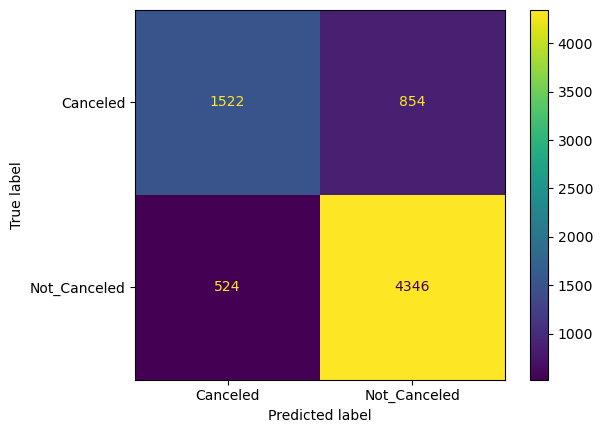

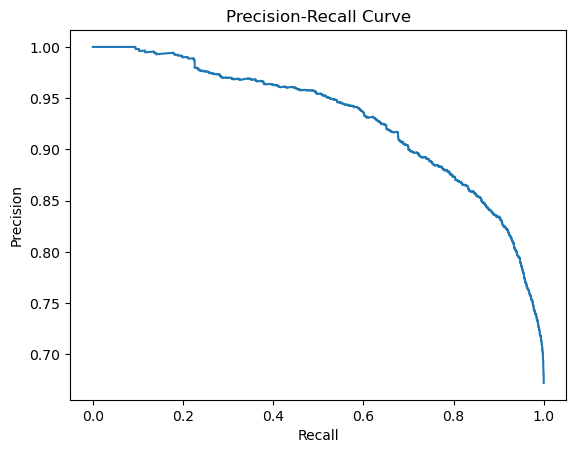

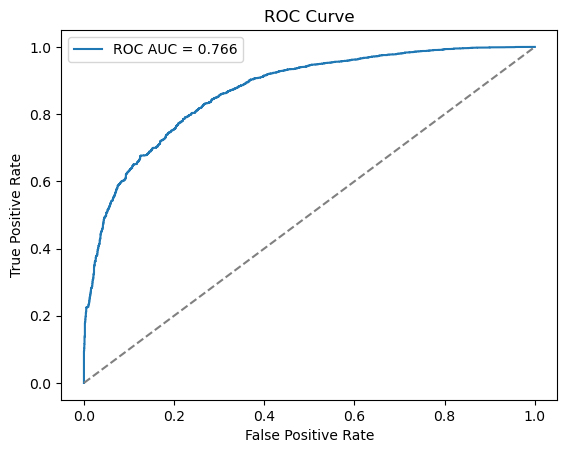

In [28]:
# Confusion Matrix
y_pred = logreg_oob.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, logreg_oob.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, logreg_oob.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Prompt:**
<div class="alert alert-block alert-info">
Help me to explode the feature space by considering feature interactions and polynomial terms. Start small by considering only feature interactions first.

</div>

In [29]:
X_train_transformed

,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online,arrival_weekday_Monday,arrival_weekday_Saturday,arrival_weekday_Sunday,arrival_weekday_Thursday,arrival_weekday_Tuesday,arrival_weekday_Wednesday,lead_time_category,lead_time,avg_price_per_room,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_special_requests,is_weekend_arrival,total_people,is_alone,total_nights_stay,walk_in,promotional_offer,arrival_quarter,week_of_year
23208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.608047,1.123666,2,1,1,3,0,5,9,0,0,0,0,0,3,0,4,0,0,2,19
18082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.967952,-0.336520,1,0,3,6,0,12,5,0,0,0,0,0,1,1,9,0,0,4,49
7423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.538388,-0.526362,2,0,1,3,0,10,24,0,0,0,0,0,2,0,4,0,0,4,43
17652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.053713,0.463655,2,0,2,2,0,5,7,0,0,0,0,0,2,0,4,0,0,2,19
27339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.166874,0.467203,1,0,0,3,0,6,14,0,0,0,0,0,1,1,3,0,0,2,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30759,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.030493,-0.888304,2,0,2,6,0,3,31,0,0,0,1,0,2,0,8,0,0,1,13
32960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.481721,0.751079,2,0,0,3,0,6,7,0,0,0,0,0,2,0,3,0,0,2,23
32513,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.143654,-0.512168,2,0,0,2,0,3,18,0,0,0,0,1,2,0,2,0,0,1,11
33383,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.944732,1.446575,2,2,0,1,0,12,19,0,0,0,0,0,4,0,1,0,0,4,51


In [30]:
# Select the features for interactions
interaction_features = ['lead_time', 'avg_price_per_room', 'no_of_special_requests']

# Configure PolynomialFeatures
poly_transfomer = (Pipeline(steps=[
                      ('poly', PolynomialFeatures(degree=2, 
                                                  interaction_only=True, 
                                                  include_bias=False))
                    ])
                   .set_output(transform='pandas'))

preprocessor_poly = (ColumnTransformer(
                        transformers=[('poly', poly_transfomer, interaction_features)], 
                        n_jobs=-1, 
                        remainder='passthrough', 
                        verbose=1)
                     .set_output(transform='pandas'))

pipeline_poly_logreg = Pipeline(steps = [
    ('tweak_features', TweakFeatures()),
    ('col_trans', col_trans),
    ('feature_poly', preprocessor_poly),
])

In [31]:
X_train_transformed = (pipeline_poly_logreg
                       .fit_transform(X_train, 
                                      (y_train
                                       .drop(faulty_date_obs_train)
                                       .values
                                       .ravel())))

2024-04-13 14:42:58.701 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23216 x 18
2024-04-13 14:42:58.705 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:42:58.706 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23195 x 17


[ColumnTransformer]  (2 of 4) Processing orde_categorical_features, total=   0.0s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
[ColumnTransformer]  (3 of 4) Processing standard_numerical_features, total=   0.0s
[ColumnTransformer]  (1 of 4) Processing ohe_categorical_features, total=   0.0s
[ColumnTransformer] .......... (1 of 2) Processing poly, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


In [32]:
X_train_transformed

,poly__lead_time,poly__avg_price_per_room,poly__no_of_special_requests,poly__lead_time avg_price_per_room,poly__lead_time no_of_special_requests,poly__avg_price_per_room no_of_special_requests,remainder__type_of_meal_plan_Meal Plan 2,remainder__type_of_meal_plan_Meal Plan 3,remainder__type_of_meal_plan_Not Selected,remainder__room_type_reserved_Room_Type 2,remainder__room_type_reserved_Room_Type 3,remainder__room_type_reserved_Room_Type 4,remainder__room_type_reserved_Room_Type 5,remainder__room_type_reserved_Room_Type 6,remainder__room_type_reserved_Room_Type 7,remainder__market_segment_type_Complementary,remainder__market_segment_type_Corporate,remainder__market_segment_type_Offline,remainder__market_segment_type_Online,remainder__arrival_weekday_Monday,remainder__arrival_weekday_Saturday,remainder__arrival_weekday_Sunday,remainder__arrival_weekday_Thursday,remainder__arrival_weekday_Tuesday,remainder__arrival_weekday_Wednesday,remainder__lead_time_category,remainder__no_of_adults,remainder__no_of_children,remainder__no_of_weekend_nights,remainder__no_of_week_nights,remainder__required_car_parking_space,remainder__arrival_month,remainder__arrival_date,remainder__repeated_guest,remainder__no_of_previous_cancellations,remainder__no_of_previous_bookings_not_canceled,remainder__is_weekend_arrival,remainder__total_people,remainder__is_alone,remainder__total_nights_stay,remainder__walk_in,remainder__promotional_offer,remainder__arrival_quarter,remainder__week_of_year
23208,-0.608047,1.123666,0.0,-0.683242,-0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1,1,3,0,5,9,0,0,0,0,3,0,4,0,0,2,19
18082,-0.967952,-0.336520,0.0,0.325735,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0,3,6,0,12,5,0,0,0,0,1,1,9,0,0,4,49
7423,-0.538388,-0.526362,0.0,0.283387,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0,1,3,0,10,24,0,0,0,0,2,0,4,0,0,4,43
17652,0.053713,0.463655,0.0,0.024904,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2,0,2,2,0,5,7,0,0,0,0,2,0,4,0,0,2,19
27339,-0.166874,0.467203,0.0,-0.077964,-0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0,0,3,0,6,14,0,0,0,0,1,1,3,0,0,2,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30759,0.030493,-0.888304,1.0,-0.027087,0.030493,-0.888304,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,0,2,6,0,3,31,0,0,0,0,2,0,8,0,0,1,13
32960,1.481721,0.751079,0.0,1.112890,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0,0,3,0,6,7,0,0,0,0,2,0,3,0,0,2,23
32513,-0.143654,-0.512168,0.0,0.073575,-0.000000,-0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,0,0,2,0,3,18,0,0,0,1,2,0,2,0,0,1,11
33383,-0.944732,1.446575,0.0,-1.366626,-0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2,2,0,1,0,12,19,0,0,0,0,4,0,1,0,0,4,51


In [33]:
logreg_poly = LogisticRegression(solver='liblinear',
                                 random_state=42)
(logreg_poly
 .fit(X_train_transformed, 
      (y_train
       .drop(faulty_date_obs_train)
       .values
       .ravel())))

LogisticRegression(random_state=42, solver='liblinear')

In [34]:
X_test_transformed = pipeline_poly_logreg.transform(X_test)
y_pred = logreg_poly.predict(X_test_transformed)
faulty_date_obs_test = TweakFeatures().get_faulty_date_index(X_test)

2024-04-13 14:43:05.126 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 7255 x 18
2024-04-13 14:43:05.130 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:43:05.130 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 7246 x 17


In [35]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.811620204250621
Precision: 0.8351501243067508
Recall: 0.8967145790554415
F1 Score: 0.8648381027824537
ROC AUC: 0.7669599831304144


In [36]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.75      0.64      0.69      2376
Not_Canceled       0.84      0.90      0.86      4870

    accuracy                           0.81      7246
   macro avg       0.79      0.77      0.78      7246
weighted avg       0.81      0.81      0.81      7246



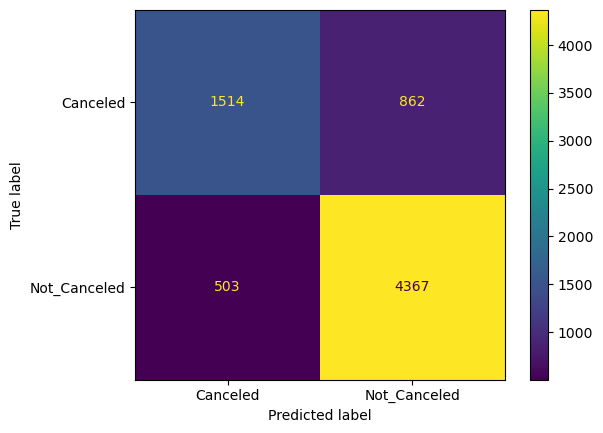

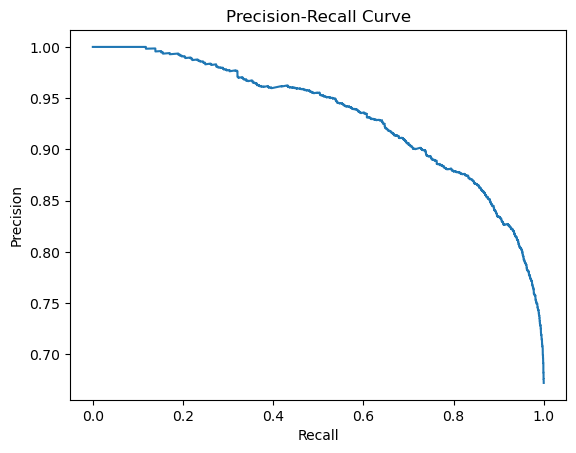

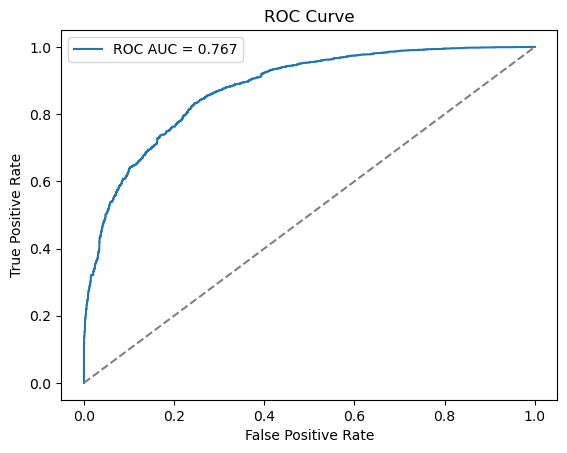

In [37]:
# Confusion Matrix
y_pred = logreg_poly.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, logreg_poly.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, logreg_poly.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Prompt:**
<div class="alert alert-block alert-info">
Now I would like to have feature selection. Please choose to include only influential features in model building. Recommend some ways in which feature selection can be done.

</div>

In [38]:
# Wrapper Method Example (RFE)
estimator = LogisticRegression(solver= 'liblinear',
                               C=1,
                               penalty='l1',
                               random_state=42)
selector = (RFE(estimator, 
                n_features_to_select=10, 
                step=1)
            .set_output(transform='pandas'))

In [39]:
pipeline_poly_sel_logreg = Pipeline(steps = [
    ('tweak_features', TweakFeatures()),
    ('col_trans', col_trans),
    ('feature_poly', preprocessor_poly),
    ('feature_select', selector)
])

In [40]:
X_train_transformed = (pipeline_poly_sel_logreg
                       .fit_transform(X_train, 
                                      (y_train
                                       .drop(faulty_date_obs_train)
                                       .values
                                       .ravel())))

2024-04-13 14:43:08.189 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23216 x 18
2024-04-13 14:43:08.193 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:43:08.194 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 23195 x 17


[ColumnTransformer]  (3 of 4) Processing standard_numerical_features, total=   0.0s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 4) Processing ohe_categorical_features, total=   0.0s
[ColumnTransformer]  (2 of 4) Processing orde_categorical_features, total=   0.0s
[ColumnTransformer] .......... (1 of 2) Processing poly, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


In [41]:
X_train_transformed

,poly__lead_time,poly__no_of_special_requests,remainder__room_type_reserved_Room_Type 5,remainder__market_segment_type_Complementary,remainder__market_segment_type_Corporate,remainder__market_segment_type_Offline,remainder__required_car_parking_space,remainder__repeated_guest,remainder__walk_in,remainder__promotional_offer
23208,-0.608047,0.0,0.0,0.0,0.0,0.0,0,0,0,0
18082,-0.967952,0.0,0.0,0.0,1.0,0.0,0,0,0,0
7423,-0.538388,0.0,0.0,0.0,0.0,1.0,0,0,0,0
17652,0.053713,0.0,0.0,0.0,0.0,0.0,0,0,0,0
27339,-0.166874,0.0,0.0,0.0,0.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
30759,0.030493,1.0,0.0,0.0,0.0,0.0,0,0,0,0
32960,1.481721,0.0,0.0,0.0,0.0,1.0,0,0,0,0
32513,-0.143654,0.0,0.0,0.0,0.0,0.0,0,0,0,0
33383,-0.944732,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [42]:
logreg_poly_sel = LogisticRegression(solver='liblinear',
                                     random_state=42)
(logreg_poly_sel
 .fit(X_train_transformed,
      (y_train
       .drop(faulty_date_obs_train)
       .values
       .ravel())))

LogisticRegression(random_state=42, solver='liblinear')

In [43]:
X_test_transformed = pipeline_poly_sel_logreg.transform(X_test)
y_pred = logreg_poly_sel.predict(X_test_transformed)
faulty_date_obs_test = TweakFeatures().get_faulty_date_index(X_test)

2024-04-13 14:43:35.426 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 7255 x 18
2024-04-13 14:43:35.430 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-13 14:43:35.430 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 7246 x 17


In [44]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.7878829699144355
Precision: 0.810508664058133
Recall: 0.893223819301848
F1 Score: 0.8498583569405099
ROC AUC: 0.7325967581357726


In [45]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.72      0.57      0.64      2376
Not_Canceled       0.81      0.89      0.85      4870

    accuracy                           0.79      7246
   macro avg       0.77      0.73      0.74      7246
weighted avg       0.78      0.79      0.78      7246



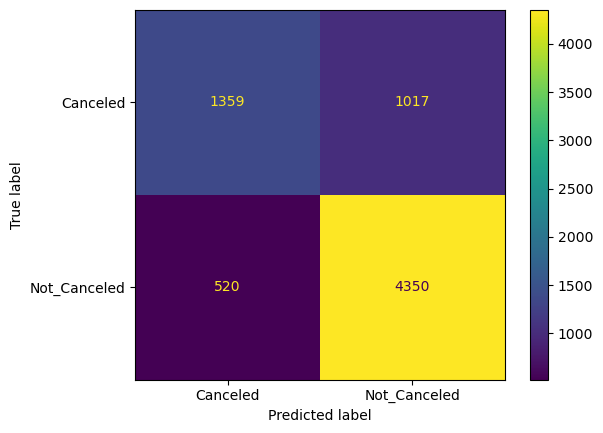

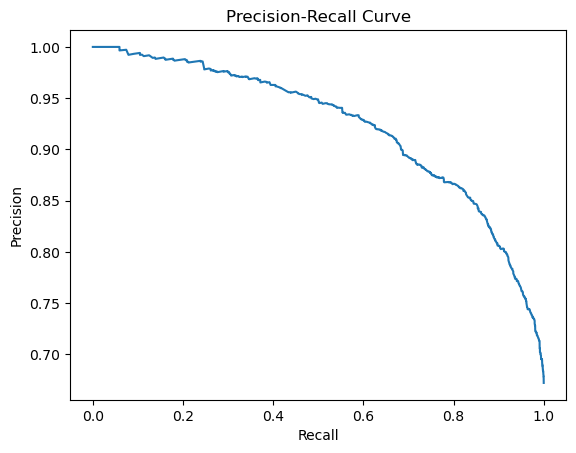

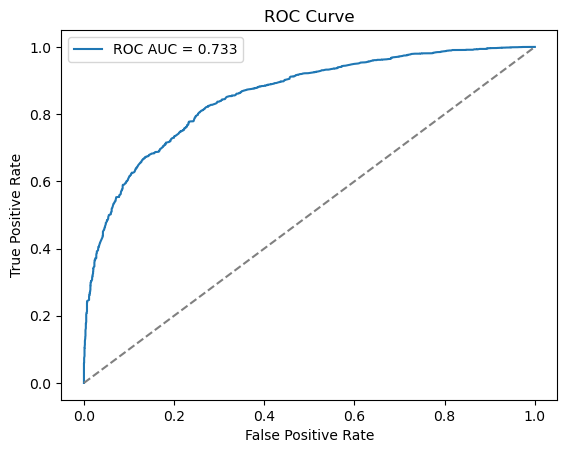

In [46]:
# Confusion Matrix
y_pred = logreg_poly_sel.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, logreg_poly_sel.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, logreg_poly_sel.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Prompt:**
<div class="alert alert-block alert-info">
Let’s perform hyperparameter tuning to optimise the model performance. Start small by considering only a few combinations of hyperparameters.

</div>

In [47]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000],
    'random_state': [42]
}

In [48]:
grid_search = GridSearchCV(estimator=logreg_poly_sel, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1)

In [49]:
start_time = time.time()
grid_search.fit(X_train_transformed, y_train.drop(faulty_date_obs_train).values.ravel())

best_model = grid_search.best_estimator_
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")
print(grid_search.best_params_)  # Best hyperparameter combination found
print(grid_search.best_score_)  # Best performance metric achieved

Time taken: 1.31 seconds
{'C': 0.1, 'max_iter': 10000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
0.7859452468204354


In [50]:
y_pred = grid_search.best_estimator_.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.788296991443555
Precision: 0.808660251665433
Recall: 0.8973305954825462
F1 Score: 0.8506910648238272
ROC AUC: 0.7310727051486806


In [51]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.73      0.56      0.64      2376
Not_Canceled       0.81      0.90      0.85      4870

    accuracy                           0.79      7246
   macro avg       0.77      0.73      0.74      7246
weighted avg       0.78      0.79      0.78      7246



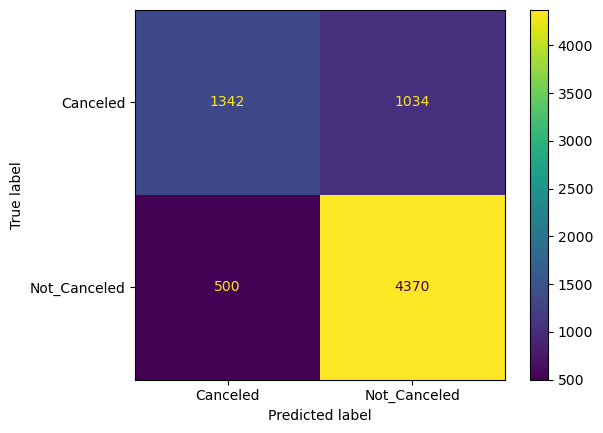

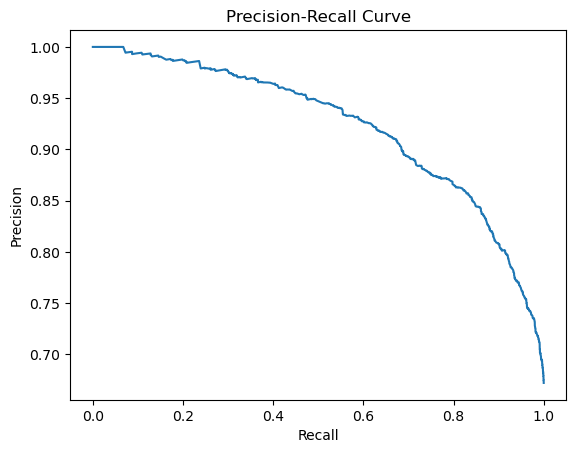

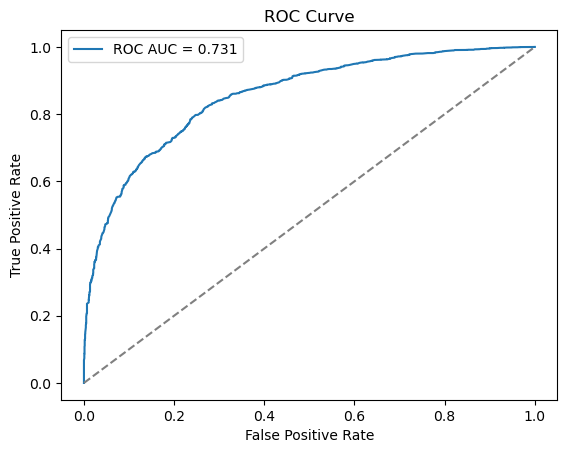

In [52]:
# Confusion Matrix
y_pred = grid_search.best_estimator_.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, grid_search.best_estimator_.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, grid_search.best_estimator_.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Prompt:**
<div class="alert alert-block alert-info">
Can you also use Hyperopt to perform hyperparameter tuning?

</div>

In [53]:
def objective_function(params):
    # Unpack parameters
    penalty = params['penalty']
    C = params['C']
    solver = params['solver']
    max_iter = params['max_iter']

    # Create a new instance of your pipeline from the defined parameters
    model = Pipeline(steps=[
        ('classifier', LogisticRegression(penalty=penalty, 
                                          C=C, 
                                          solver=solver, 
                                          max_iter=max_iter,
                                          random_state=42))
    ])

    # Evaluation with cross-validation
    scores = cross_val_score(model, 
                             X_train_transformed, 
                             y_train.drop(faulty_date_obs_train).values.ravel(), 
                             cv=5, 
                             scoring='roc_auc',
                             n_jobs=-1)  # Example metric
    
    mean_score = scores.mean()
    return 1 - mean_score  # Hyperopt minimizes, we want to maximize ROC AUC


In [54]:
search_space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.uniform('C', 0.01, 10),
    'solver': hp.choice('solver', ['liblinear', 'saga']),
    'max_iter': hp.choice('max_iter', [10000]),
    'random_state': hp.choice('random_state', [42])
}

In [55]:
trials = Trials()
SEED = 101

# Run the hyperparameter search
best = fmin(fn=objective_function,
            space=search_space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials,
            rstate=np.random.default_rng(SEED)
)

100%|██████████| 20/20 [00:04<00:00,  4.50trial/s, best loss: 0.14755199964479604]


In [56]:
best

{'C': 0.6477984056450444,
 'max_iter': 0,
 'penalty': 1,
 'random_state': 0,
 'solver': 0}

In [57]:
# Define mappings for penalty and solver
penalty_map = {0: 'l1', 1: 'l2'}
solver_map = {0: 'liblinear', 1: 'saga'}
max_iter_map = {0: 10000}
random_state_map = {0: 42}

# Map the indices to the actual values
best['penalty'] = penalty_map[best['penalty']]
best['solver'] = solver_map[best['solver']]
best['max_iter'] = max_iter_map[best['max_iter']]
best['random_state'] = random_state_map[best['random_state']]

best

{'C': 0.6477984056450444,
 'max_iter': 10000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear'}

In [58]:
logreg_hyperopt = (LogisticRegression(**best)
                   .fit(X_train_transformed, 
                        (y_train
                         .drop(faulty_date_obs_train)
                         .values
                         .ravel())))

In [59]:
y_pred = logreg_hyperopt.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.7877449627380624
Precision: 0.8104733507267984
Recall: 0.8930184804928132
F1 Score: 0.8497459945291129
ROC AUC: 0.7324940887312551


In [60]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), 
                            label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.72      0.57      0.64      2376
Not_Canceled       0.81      0.89      0.85      4870

    accuracy                           0.79      7246
   macro avg       0.77      0.73      0.74      7246
weighted avg       0.78      0.79      0.78      7246



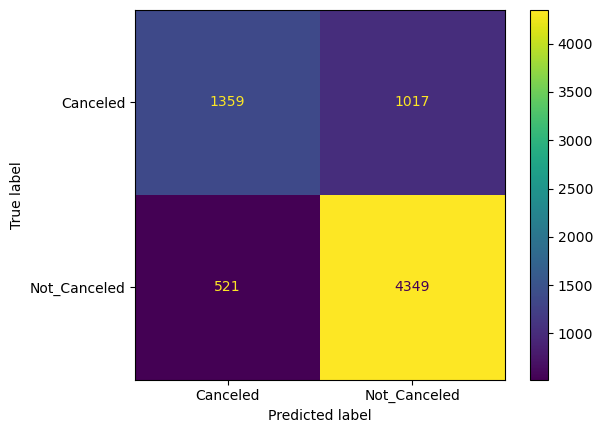

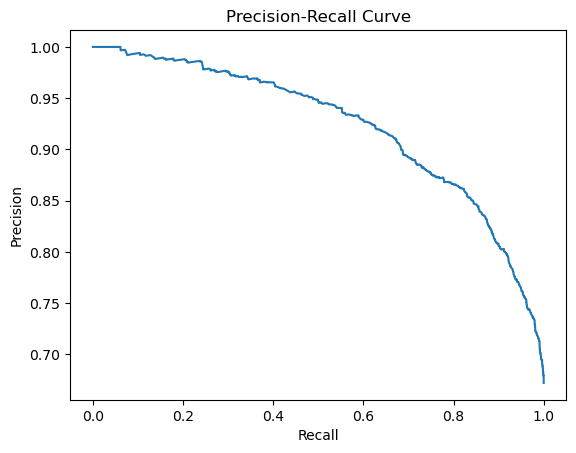

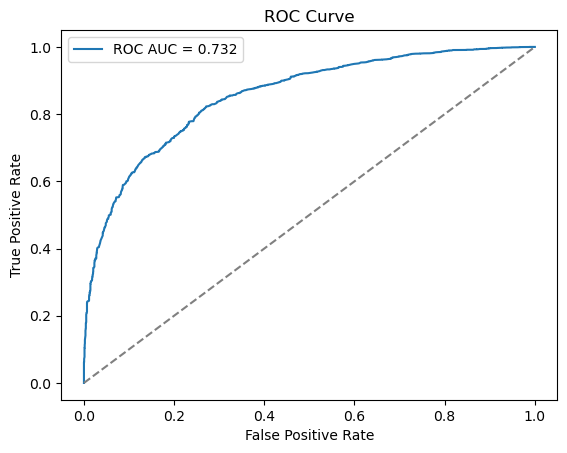

In [61]:
# Confusion Matrix
y_pred = logreg_hyperopt.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, logreg_hyperopt.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, logreg_hyperopt.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Prompt:**
<div class="alert alert-block alert-info">
I am done with the Logistic Regression model. Can we explore other models like XGBoost?

</div>

In [62]:
# Example XGBoost model (adapt parameters as needed)
start_time = time.time()
xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                              n_jobs=-1,
                              seed=42)

# Parameters to tune (refer to XGBoost documentation for more options)
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10],
    'n_estimators': [100, 250, 500],
    'gamma': [0, 0.1, 0.2],
    'random_state': [42]
}

# Choose between GridSearchCV or RandomizedSearchCV
search = GridSearchCV(xgb_model, 
                      param_grid, 
                      cv=5, 
                      scoring='roc_auc', 
                      n_jobs=-1)

search.fit(X_train_transformed, y_train.drop(faulty_date_obs_train).values.ravel())

best_model_xgb = search.best_estimator_
y_pred = best_model_xgb.predict(X_test_transformed)
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

Time taken: 75.09 seconds


In [63]:
search.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 250,
 'random_state': 42}

In [64]:
y_pred = best_model_xgb.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8343913883521943
Precision: 0.8707070707070707
Recall: 0.8850102669404517
F1 Score: 0.8778004073319755
ROC AUC: 0.8078249987900913


In [65]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), 
                            label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.76      0.73      0.74      2376
Not_Canceled       0.87      0.89      0.88      4870

    accuracy                           0.83      7246
   macro avg       0.81      0.81      0.81      7246
weighted avg       0.83      0.83      0.83      7246



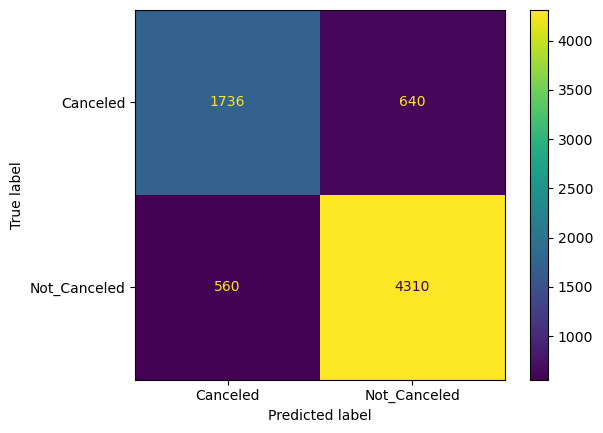

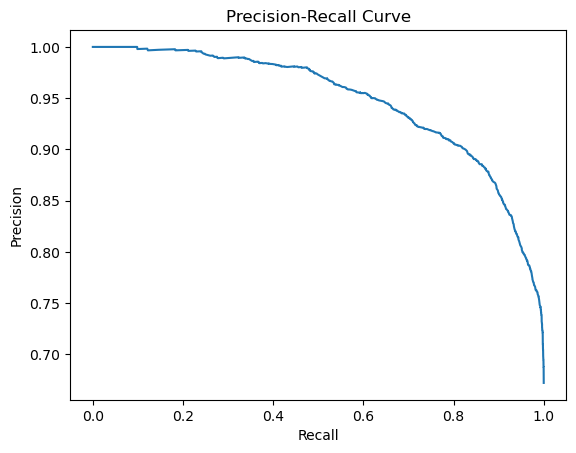

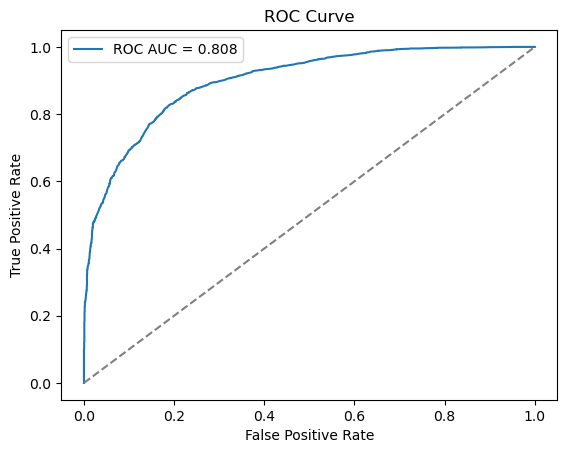

In [66]:
# Confusion Matrix
y_pred = best_model_xgb.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_model_xgb.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, best_model_xgb.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Prompt:**
<div class="alert alert-block alert-info">

I am done with the XGBoost model. Can we explore other models like SVC?
</div>

In [67]:
start_time = time.time()
svc_model = SVC(kernel='rbf', 
                C=1, 
                gamma='scale', 
                probability=True,
                random_state=42)  # probability=True for ROC AUC

# Parameters to tune (refer to SVC documentation for other options)
param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': [0.01, 0.1],
    'kernel': ['rbf', 'linear'], # You can explore different kernels
    'random_state': [42]
}

# Choose between GridSearchCV or RandomizedSearchCV
search = RandomizedSearchCV(svc_model,
                            param_grid,
                            cv=5,
                            scoring='roc_auc',
                            n_jobs=-1)  # Or use RandomizedSearchCV

search.fit(X_train_transformed, y_train.drop(faulty_date_obs_train).values.ravel())

best_model_svc = search.best_estimator_
y_pred = best_model_svc.predict(X_test_transformed)
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

/Users/andreaslukita7/Data/DSA_ML/Python/Analysis/hotel_reservation/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken: 207.10 seconds


In [68]:
y_pred = best_model_svc.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.791471156500138
Precision: 0.8143365150664421
Recall: 0.893429158110883
F1 Score: 0.8520513071575443
ROC AUC: 0.7379603703012327


In [69]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), 
                            label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.73      0.58      0.65      2376
Not_Canceled       0.81      0.89      0.85      4870

    accuracy                           0.79      7246
   macro avg       0.77      0.74      0.75      7246
weighted avg       0.79      0.79      0.78      7246



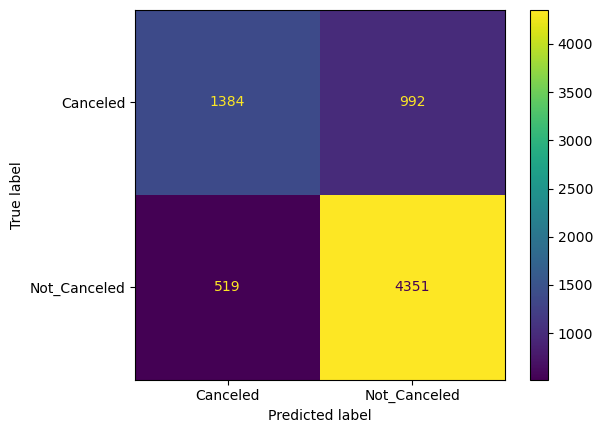

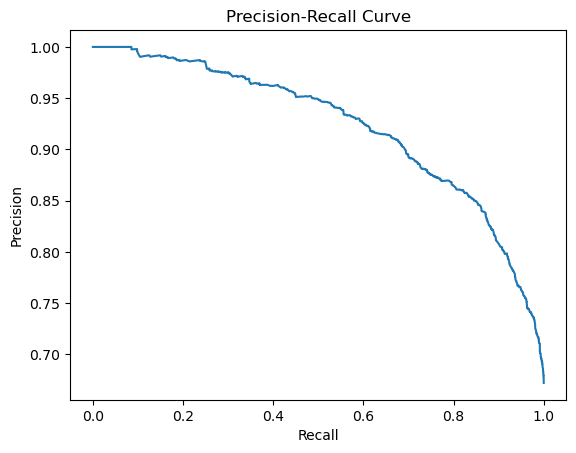

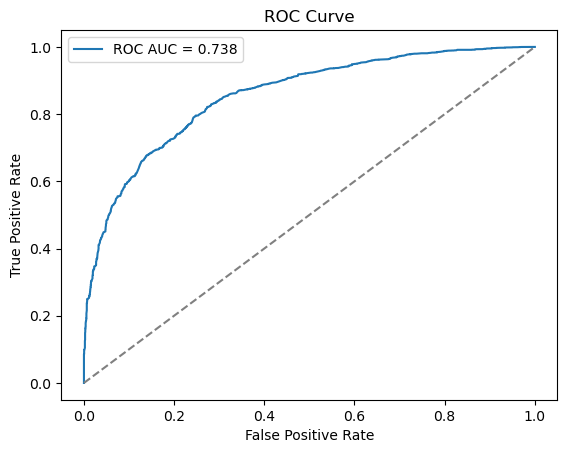

In [70]:
# Confusion Matrix
y_pred = best_model_svc.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_model_svc.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, best_model_svc.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Export Model

In [71]:
pipeline_to_dump = pipeline_poly_sel_logreg
dump(pipeline_to_dump, '../../models/pipeline.joblib')

['../../models/pipeline.joblib']

In [72]:
model_to_dump = logreg_hyperopt
dump(model_to_dump, '../../models/best_model_logreg.joblib')

['../../models/best_model_logreg.joblib']

In [73]:
model_to_dump = best_model_xgb
dump(model_to_dump, '../../models/best_model_xgb.joblib')

['../../models/best_model_xgb.joblib']

In [74]:
model_to_dump = best_model_svc
dump(model_to_dump, '../../models/best_model_svc.joblib')

['../../models/best_model_svc.joblib']

# Voting Classifier

In [75]:
clf1 = logreg_hyperopt
clf2 = best_model_xgb
clf3 = best_model_svc

eclf = VotingClassifier(estimators=[('logreg', clf1), 
                                    ('xgb', clf2), 
                                    ('svc', clf3)],
                        voting='soft',
                        weights=[0.2, 0.5, 0.3],
                        n_jobs=-1)

In [76]:
eclf = eclf.fit(X_train_transformed, y_train.drop(faulty_date_obs_train).values.ravel())
print(eclf.predict(X_test_transformed))

[0 1 1 ... 1 0 1]


In [77]:
y_pred = eclf.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8312172232956113
Precision: 0.8571988246816846
Recall: 0.8985626283367556
F1 Score: 0.8773934837092732
ROC AUC: 0.7958722232592869


In [78]:
print(classification_report(label_encoder.inverse_transform(y_test.values.ravel()), 
                            label_encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

    Canceled       0.77      0.69      0.73      2376
Not_Canceled       0.86      0.90      0.88      4870

    accuracy                           0.83      7246
   macro avg       0.81      0.80      0.80      7246
weighted avg       0.83      0.83      0.83      7246



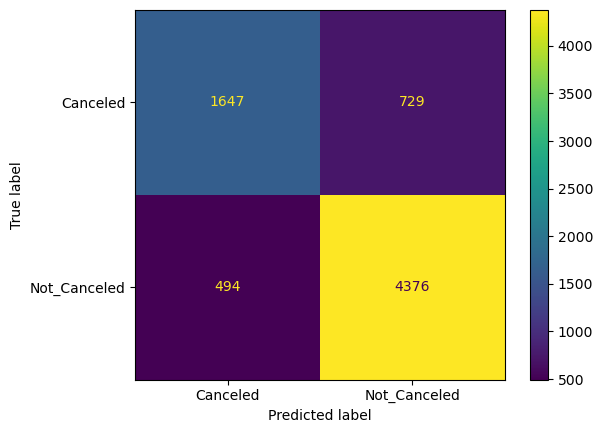

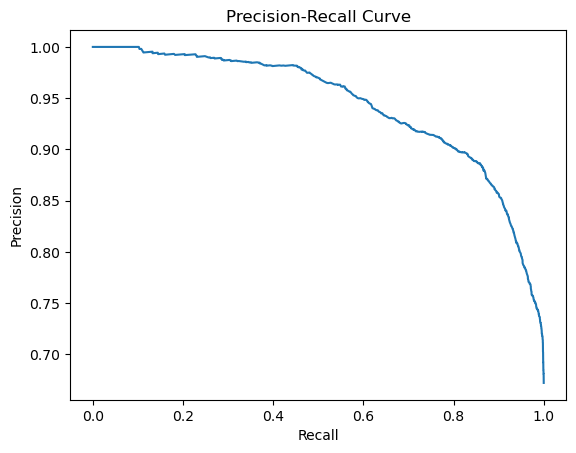

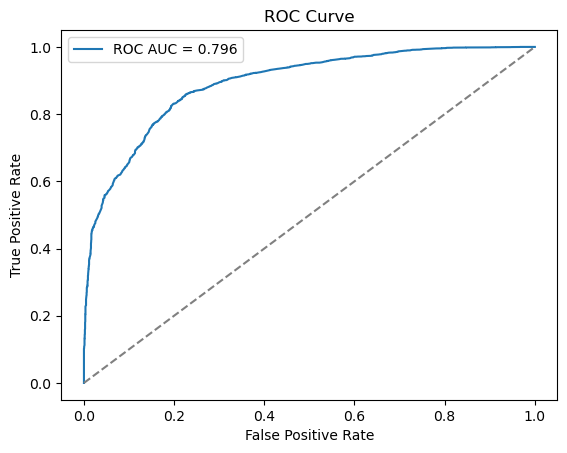

In [79]:
# Confusion Matrix
y_pred = eclf.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, eclf.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, eclf.predict_proba(X_test_transformed)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test, y_pred) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [81]:
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, eclf.predict_proba(X_test_transformed)[:,1] > thr) for thr in thresholds]

# Get threshold with highest F1 score
optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]

print(f'Optimal threshold based on f1: {optimal_threshold_f1}')

In [93]:
# Generate predicted probabilities
y_prob = eclf.predict_proba(X_test_transformed)[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_f1 = (y_prob >= optimal_threshold_f1).astype(int)

In [95]:
print('Threshold adjusted based on F1...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_f1)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_f1)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, eclf.predict_proba(X_test_transformed)[:, 1])}')

Threshold adjusted based on F1...

Accuracy score: 0.8796577422025945
Precision score: 0.8961553705905668
Recall score: 0.9285420944558521
F1 score: 0.9120613150463897
ROC-AUC score: 0.9307882901568734


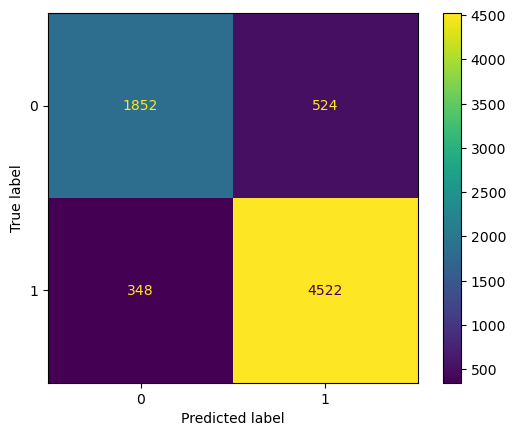

In [96]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_f1)).plot();

In [99]:
thresholds = np.linspace(0, 1, 100)
fbeta_scores = [fbeta_score(y_test, eclf.predict_proba(X_test_transformed)[:,1] > thr, beta=0.5) for thr in thresholds]

# Get threshold with highest FBeta score
optimal_threshold_fbeta = thresholds[np.argmax(fbeta_scores)]

print(f'Optimal threshold based on fbeta: {optimal_threshold_fbeta}')

Optimal threshold based on fbeta: 0.6767676767676768


In [100]:
# Generate predicted probabilities
y_prob = eclf.predict_proba(X_test_transformed)[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_fbeta = (y_prob >= optimal_threshold_fbeta).astype(int)

In [101]:
print('Threshold adjusted based on FBeta (Precision 2.0x more important than Recall)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, eclf.predict_proba(X_test_transformed)[:, 1])}')

Threshold adjusted based on FBeta (Precision 2.0x more important than Recall)...

Accuracy score: 0.8632348882141871
Precision score: 0.9182661203364244
Recall score: 0.8743326488706366
F1 score: 0.895761018197118
ROC-AUC score: 0.9307882901568734


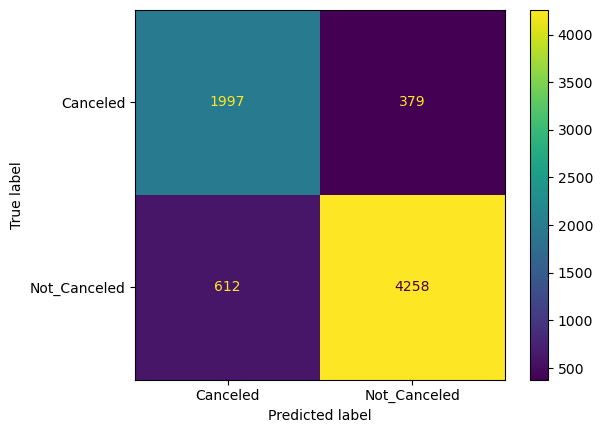

In [103]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_fbeta),
                       display_labels=label_encoder.inverse_transform([0, 1])).plot();

In [82]:
thresholds = np.linspace(0, 1, 100)
fbeta_scores = [fbeta_score(y_test, eclf.predict_proba(X_test_transformed)[:,1] > thr, beta=1.5) for thr in thresholds]

# Get threshold with highest FBeta score
optimal_threshold_fbeta = thresholds[np.argmax(fbeta_scores)]

print(f'Optimal threshold based on fbeta: {optimal_threshold_fbeta}')

Optimal threshold based on fbeta: 0.30303030303030304


In [83]:
# Generate predicted probabilities
y_prob = eclf.predict_proba(X_test_transformed)[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_fbeta = (y_prob >= optimal_threshold_fbeta).astype(int)

In [84]:
print('Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, eclf.predict_proba(X_test_transformed)[:, 1])}')

Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...

Accuracy score: 0.7833287330941209
Precision score: 0.7680311890838206
Recall score: 0.9708418891170432
F1 score: 0.8576092871394885
ROC-AUC score: 0.8923220915520711


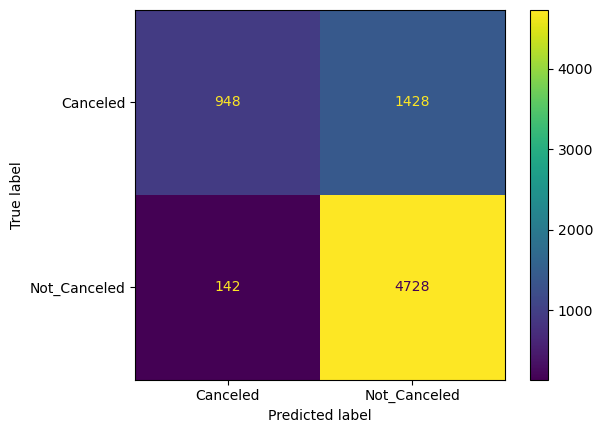

In [85]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_fbeta),
                       display_labels=label_encoder.inverse_transform([0, 1])).plot();

In [86]:
model_to_dump = eclf
dump(model_to_dump, '../../models/best_model_voting_soft.joblib')

['../../models/best_model_voting_soft.joblib']

### Predicting for June 2018

In [14]:
pipeline = load('../../models/pipeline.joblib')
pipeline

Pipeline(steps=[('tweak_features', TweakFeatures()),
                ('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('ohe_categorical_features',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'arrival_weekday']),
                                                 ('orde_cat...
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['lead_time',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests'])],
                                   verbose=1)),
                ('feature_select',
                 RFE(estimator=LogisticRegression(C=1, penalty='l1',
                                                  random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=10))])

In [16]:
model = load('../../models/best_model_voting_soft.joblib')
model

VotingClassifier(estimators=[('logreg',
                              LogisticRegression(C=0.6477984056450444,
                                                 max_iter=10000,
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=250, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('svc',
                              SVC(C=10, gamma=0.01, kernel='linear',
                                  probability=True, random_state=42))],
                 n_jobs=-1, voting='soft', weights=[0.2, 0.5, 0.3])

In [17]:
june_2018 = (data
             .assign(year_month=lambda df_: df_['arrival_year'].astype('str') + '_' + df_['arrival_month'].astype('str'))
             .loc[lambda df_: df_['year_month'].eq('2018_6')]
             )
june_2018

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,year_month
15,INN00016,2,0,0,2,Meal Plan 2,0,Room_Type 1,256,2018,6,15,Online,0,0,0,115.00,1,Canceled,2018_6
36,INN00037,1,0,2,1,Meal Plan 1,0,Room_Type 1,34,2018,6,19,Online,0,0,0,81.00,0,Canceled,2018_6
41,INN00042,2,0,0,2,Meal Plan 1,0,Room_Type 1,35,2018,6,21,Online,0,0,0,102.00,1,Not_Canceled,2018_6
43,INN00044,2,0,1,1,Not Selected,0,Room_Type 1,41,2018,6,27,Online,0,0,0,98.10,1,Canceled,2018_6
54,INN00055,2,0,1,0,Not Selected,0,Room_Type 1,13,2018,6,13,Online,0,0,0,89.00,2,Not_Canceled,2018_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36220,INN36221,2,0,2,5,Not Selected,0,Room_Type 1,41,2018,6,27,Online,0,0,0,104.53,0,Canceled,2018_6
36226,INN36227,1,0,2,3,Meal Plan 1,0,Room_Type 4,66,2018,6,26,Online,0,0,0,122.72,0,Not_Canceled,2018_6
36231,INN36232,2,1,0,2,Meal Plan 1,0,Room_Type 1,1,2018,6,28,Online,0,0,0,167.00,1,Not_Canceled,2018_6
36241,INN36242,2,0,0,2,Meal Plan 2,0,Room_Type 1,256,2018,6,15,Offline,0,0,0,115.00,1,Canceled,2018_6


In [21]:
label_encoder = LabelEncoder()
y_test_june_2018 = (pd
                    .DataFrame(label_encoder.fit_transform(june_2018['booking_status']), 
                                columns=['booking_status'],
                                index=june_2018.index)
                    .astype({'booking_status': 'int8'})
                    )

y_test_june_2018

,booking_status
15,0
36,0
41,1
43,0
54,1
...,...
36220,0
36226,1
36231,1
36241,0


In [29]:
optimal_threshold_fbeta = 0.303

In [30]:
X_test_june_2018 = pipeline.transform(june_2018)
y_pred_june_2018 = model.predict(X_test_june_2018)
y_pred_june_2018

2024-04-15 16:30:22.729 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 3203 x 20
2024-04-15 16:30:22.735 | INFO     | __main__:pipe_logger:3 - After dropping leap year error...
2024-04-15 16:30:22.735 | INFO     | __main__:pipe_logger:4 - Shape of DataFrame: 3203 x 19


array([0, 0, 1, ..., 1, 0, 1], dtype=int8)

In [31]:
faulty_date_obs_june_2018 = TweakFeatures().get_faulty_date_index(june_2018)
y_test_june_2018 = y_test_june_2018.drop(faulty_date_obs_june_2018)

In [32]:
# Generate predicted probabilities
y_prob_june_2018 = model.predict_proba(X_test_june_2018)[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_fbeta_june_2018 = (y_prob_june_2018 >= optimal_threshold_fbeta).astype(int)

In [33]:
accuracy = accuracy_score(y_test_june_2018, y_pred_adj_threshold_fbeta_june_2018)
precision = precision_score(y_test_june_2018, y_pred_adj_threshold_fbeta_june_2018)
recall = recall_score(y_test_june_2018, y_pred_adj_threshold_fbeta_june_2018)
f1 = f1_score(y_test_june_2018, y_pred_adj_threshold_fbeta_june_2018)
roc_auc = roc_auc_score(y_test_june_2018, y_pred_adj_threshold_fbeta_june_2018)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.758663752731814
Precision: 0.719629772464327
Recall: 0.9759414225941423
F1 Score: 0.8284128745837958
ROC AUC: 0.7064060327533066


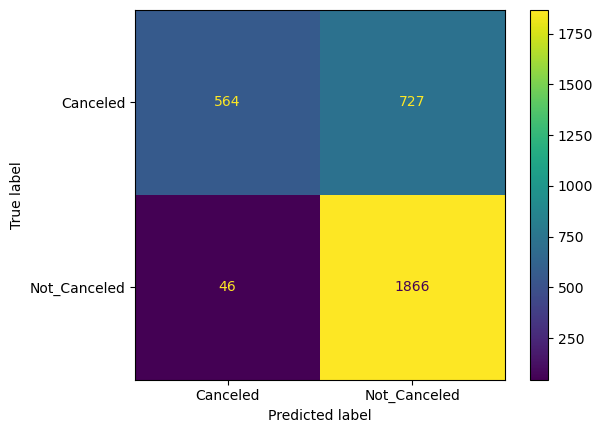

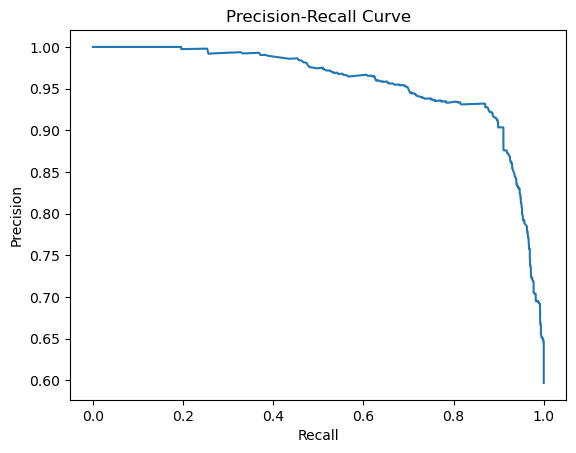

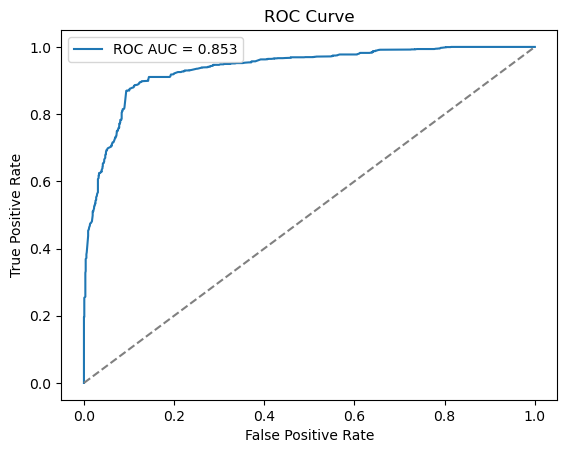

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test_june_2018, y_pred_adj_threshold_fbeta_june_2018)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform([0, 1]))
disp.plot()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_june_2018, model.predict_proba(X_test_june_2018)[:, 1])  # Positive class probability
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test_june_2018, model.predict_proba(X_test_june_2018)[:, 1])  # Positive class probability
roc_auc = roc_auc_score(y_test_june_2018, y_pred_june_2018) 
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()